In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



Tennis is a racquet sport that can be played by two teams of two players each or by an individual versus a single opponent (singles). The data we used this time will focus on singles stats. These athletes compete in a multitude of tournaments all over the globe, streamed for the world to enjoy. While loving the game, our group wonders questions such as does the playstyles (left-handed or right-handed) and the backhand habit (one-handed or two-handed) of a player affect their skill level and thus the amount of prize money they could win? If yes, how much would they approximately learn if they use the playstyles that would be considered as more "skilled" and earns more for the players? We are using the player stats tennis datasets which contain different statistics of the top 500 players in the world for tennis. This includes information such as the country they are from, their preferred hand, and the prize money they have earned to answer this question.

In [3]:
player_data <- read_csv("player_stats.csv")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
player_data_renamed <- player_data |>
               rename_at(1, ~'Player Number') |>
               rename_at(10, ~'prize_money')

In [76]:
player_data_excluded <- player_data_renamed |>
                        select(-one_of('Retired', 'Masters', 'Residence', 'Coach', 'Facebook', 'Twitter', 'Nicknames', 'Web Site'))

In [6]:
set.seed(3456) 

player_data_split <- initial_split(player_data_excluded, prop = 0.75, strata = Plays)

player_data_train <- training(player_data_split)

player_data_test <- testing(player_data_split)

In [69]:
set.seed(1223)
player_data_train_goal <- player_data_train [c('Plays', 'prize_money', 'Backhand')] #data we care about the most

player_data_train_rows <- nrow(player_data_train_goal) #number of total rows in the dataframe

important_data <- group_by(player_data_train_goal, Plays, prize_money, Backhand)

player_data_train_NA <- colSums(is.na(important_data)) #provides the number of NA values

player_data_train_type <- player_data_train_goal |>
                          count(Plays, sort = TRUE) #number of observation in the the classes that we are interested with

player_data_train_type2 <- player_data_train_goal |>
                           count(Backhand, sort = TRUE) #number of observation in the the classes that we are interested with

player_data_train_goal #data we care about the most
player_data_train_rows #number of total rows in the dataframe
player_data_train_NA #provides the number of NA values
player_data_train_type #number of observation in the the classes that we are interested with
player_data_train_type2 #number of observation in the the classes that we are interested with

Plays,prize_money,Backhand
<chr>,<chr>,<chr>
Left-handed,"$54,004",Two-handed
Left-handed,"$127,760",Two-handed
Left-handed,"$60,865",Two-handed
⋮,⋮,⋮
Right-handed,"US$ 132,871",Two-handed
Right-handed,"$354,975",Two-handed
Right-handed,"$57,943",Two-handed


[1] 374

Plays prize_money    Backhand 
         36          64          69

Plays,n
<chr>,<int>
Right-handed,293
Left-handed,45
NA,36


Backhand,n
<chr>,<int>
Two-handed,272
NA,69
One-handed,33


Plays,prize_money,Backhand
<fct>,<dbl>,<chr>
Left-handed,54004,Two-handed
Left-handed,127760,Two-handed
Left-handed,60865,Two-handed
⋮,⋮,⋮
Right-handed,132871,Two-handed
Right-handed,354975,Two-handed
Right-handed,57943,Two-handed


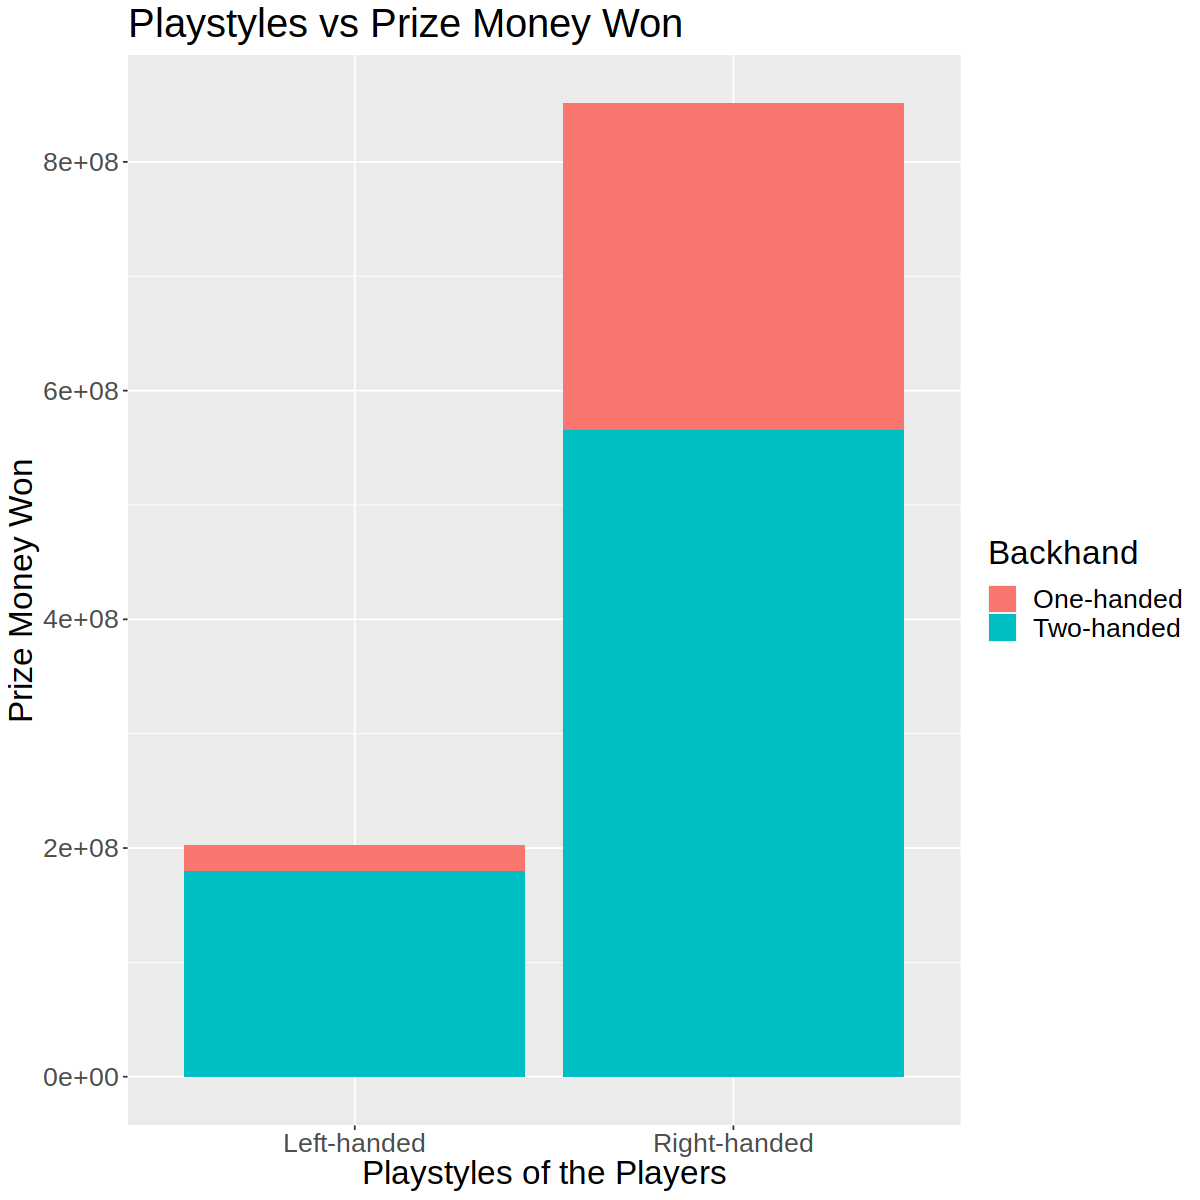

In [75]:
set.seed(6246) 
options("scipen"=0, "digits"=7)
options(repr.plot.width = 10, repr.plot.height = 10)
Plays_table <- filter(player_data_train_goal, Plays != "NA", Backhand != "NA")
player_data_train_better <-  mutate(Plays_table, Plays = as_factor(Plays), prize_money = readr::parse_number(prize_money))
player_data_train_better
player_data_train_plot <- player_data_train_better |>
                          ggplot(aes(x = Plays, y = prize_money, fill = Backhand)) +
                          geom_bar(stat = "identity") +
                          xlab("Playstyles of the Players") +
                          ylab("Prize Money Won") +
                          ggtitle("Playstyles vs Prize Money Won") +
                          theme(text = element_text(size=20))
player_data_train_plot

We will be using the play, backhand, and prize money columns for our analysis. We will need to select these columns. By using the play and backhand as the classifiers and prize money as the variable that we want to predict. We will randomly assign a value prize money to new observations and see what playstyle it will be classified as based off our dataset. We will import the data and look at it, cleaning all of the columns to make clear of the variables that we care about the most are presented, and then identify NA values as well as changing the property of the variables (chr, dbl, and etc.) to our ideal state for classification and visualization. For the visuals, we will be creating a bar-graph where we have the plays on the x-axis and prize money on the y-axis and also give backhand colours to make the graph more readable.

We are expecting to find that the playstyles of the tennis players would reflect on how much they would receive on their prize money since the different use of hand and backhand habits do provide different amount of force to the bat and has different reaction time for the muscles, which would affect how well the players handle the hits and thus affect their tournament scores and the prize money they would earn. It could show aspiring tennis players how to plan their career by informing them which hand they should practice more on and how they should do backhands to achieve a successful tennis career. These data could lead to countries taking examples from the leading tennis players in terms of what kind of training they have to produce more successful professional players for themselves.